<a href="https://colab.research.google.com/github/guilherme3987/Aprendizado_Maq/blob/main/Apt_Maq_Supervisionado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

3  # Atividade
Link para página do repositório: https://archive.ics.uci.edu/dataset/891/cdc+diabetes+health+indicators

O grupo deve:

*  Estudar e entender o repositório e todas as suas features e rótulo

*  Avaliar a necessidade de operções de pré-processamento dos dados como normalização, etc
*   Criar um modelo KNN para treinamento e testes com o dataset indicado
*   Criar um modelo de Redes Neuarais supervisionadas para treinamento e testes com o dataset indicado

*   Medir acurácia, precisão e recall com os dados de testes
*   Apresentar os resultados comparando os dois modelos e fazendo uma análise crítica que justifique as diferenças de desempenho dos dois modelos.


In [ ]:
# @title 1. Instalação e Importações
# Instala biblioteca para baixar datasets do Kaggle
!pip install -q kagglehub

import os
import sqlite3
import kagglehub
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Bibliotecas de Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, classification_report)

# Configurações de visualização
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Ambiente configurado com sucesso!")

Ambiente configurado com sucesso!


## Extração
Utilizamos a biblioteca kagglehub para baixar o dataset Diabetes Health Indicators.

Fonte: Behavioral Risk Factor Surveillance System (BRFSS) 2015.

Dados: 21 indicadores de saúde + 1 variável alvo (Diabetes_binary).

## Transformação
Nesta etapa, os dados são refinados para garantir eficiência:

Desduplicação: Remoção de registros idênticos que poderiam enviesar o treinamento.

Otimização de Tipos: Conversão de dados float para int (já que as respostas são categóricas/binárias), reduzindo o uso de memória.

Tratamento de Nulos: Verificação e limpeza de dados faltantes.

## Carga (Data Warehousing)
Diferente de scripts simples que leem CSVs a cada execução, criamos um banco de dados SQLite.

Tabela: diabetes_indicators.

Vantagem: Permite realizar consultas SQL complexas, garante integridade dos dados e simula um ambiente corporativo real.

In [ ]:
# @title 2. Execução do ETL (Extract, Transform, Load)

def run_etl_pipeline(db_name="diabetes_warehouse.db"):
    print("="*60)
    print("INICIANDO PIPELINE ETL")
    print("="*60)

    # --- 1. EXTRACT (Extração) ---
    print("\n[EXTRACT] Baixando dados do Kaggle...")
    # Usando o dataset balanceado 50/50 para melhor performance demonstrativa
    path = kagglehub.dataset_download("alexteboul/diabetes-health-indicators-dataset")
    csv_path = os.path.join(path, "diabetes_binary_5050split_health_indicators_BRFSS2015.csv")

    df_raw = pd.read_csv(csv_path)
    print(f"Dados extraídos: {df_raw.shape[0]} linhas, {df_raw.shape[1]} colunas")

    # --- 2. TRANSFORM (Transformação) ---
    print("\n[TRANSFORM] Limpando e padronizando dados...")
    df_clean = df_raw.copy()

    # Remover duplicatas (comum neste tipo de survey)
    initial_len = len(df_clean)
    df_clean.drop_duplicates(inplace=True)
    print(f"Duplicatas removidas: {initial_len - len(df_clean)}")

    # Converter floats para int
    for col in df_clean.columns:
        df_clean[col] = df_clean[col].astype(int)

    print(f"Transformação concluída. Shape final: {df_clean.shape}")

    # --- 3. LOAD (Carga no SQLite) ---
    print(f"\n[LOAD] Salvando no banco de dados '{db_name}'...")

    conn = sqlite3.connect(db_name)
    cursor = conn.cursor()

    # DDL: Definição da Tabela
    create_table_sql = """
    CREATE TABLE IF NOT EXISTS diabetes_indicators (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        Diabetes_binary INTEGER,
        HighBP INTEGER,
        HighChol INTEGER,
        CholCheck INTEGER,
        BMI INTEGER,
        Smoker INTEGER,
        Stroke INTEGER,
        HeartDiseaseorAttack INTEGER,
        PhysActivity INTEGER,
        Fruits INTEGER,
        Veggies INTEGER,
        HvyAlcoholConsump INTEGER,
        AnyHealthcare INTEGER,
        NoDocbcCost INTEGER,
        GenHlth INTEGER,
        MentHlth INTEGER,
        PhysHlth INTEGER,
        DiffWalk INTEGER,
        Sex INTEGER,
        Age INTEGER,
        Education INTEGER,
        Income INTEGER
    );
    """
    cursor.execute(create_table_sql)

    # Inserção dos dados
    df_clean.to_sql('diabetes_indicators', conn, if_exists='replace', index=False)

    # Verificação
    count = cursor.execute("SELECT count(*) FROM diabetes_indicators").fetchone()[0]
    conn.close()

    print(f" Carga Finalizada! Total de registros no banco: {count}")
    print("="*60)
    return db_name

# Executar o Pipeline
db_path = run_etl_pipeline()

INICIANDO PIPELINE ETL

[EXTRACT] Baixando dados do Kaggle...
Using Colab cache for faster access to the 'diabetes-health-indicators-dataset' dataset.
Dados extraídos: 70692 linhas, 22 colunas

[TRANSFORM] Limpando e padronizando dados...
Duplicatas removidas: 1635
Transformação concluída. Shape final: (69057, 22)

[LOAD] Salvando no banco de dados 'diabetes_warehouse.db'...
 Carga Finalizada! Total de registros no banco: 69057


🔌 Conectando ao banco: diabetes_warehouse.db...

 1. VISÃO GERAL DOS DADOS


,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0,1,0,1,26,0,0,0,1,0,...,1,0,3,5,30,0,1,4,6,8
1,0,1,1,1,26,1,1,0,0,1,...,1,0,3,0,0,0,1,12,6,8
2,0,0,0,1,26,0,0,0,1,1,...,1,0,1,0,10,0,1,13,6,8
3,0,1,1,1,28,1,0,0,1,1,...,1,0,3,0,3,0,1,11,6,8
4,0,0,0,1,29,1,0,0,1,1,...,1,0,2,0,0,0,0,8,5,8



Dimensões: 69057 registros, 22 colunas

 Estatísticas Descritivas (Média, Desvio Padrão, Min, Max):


,BMI,GenHlth,MentHlth,PhysHlth,Age,Income
count,69057.00,69057.00,69057.00,69057.00,69057.00,69057.00
mean,29.96,2.86,3.84,5.95,8.60,5.65
std,7.15,1.11,8.23,10.14,2.86,2.18
min,12.00,1.00,0.00,0.00,1.00,1.00
25%,25.00,2.00,0.00,0.00,7.00,4.00
50%,29.00,3.00,0.00,0.00,9.00,6.00
75%,33.00,4.00,3.00,6.00,11.00,8.00
max,98.00,5.00,30.00,30.00,13.00,8.00



2. DISTRIBUIÇÃO DA VARIÁVEL ALVO (Diabetes_binary)


,Diabetes_binary,Total,Porcentagem,Label
0,0,33960,49.18,Não Diabético
1,1,35097,50.82,Diabético


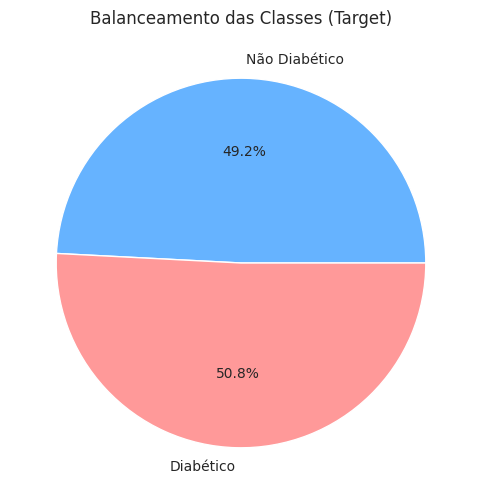


3. MAPA DE CORRELAÇÃO: O QUE MAIS IMPACTA A DIABETES?
   (Cores quentes = Maior relação positiva com Diabetes)


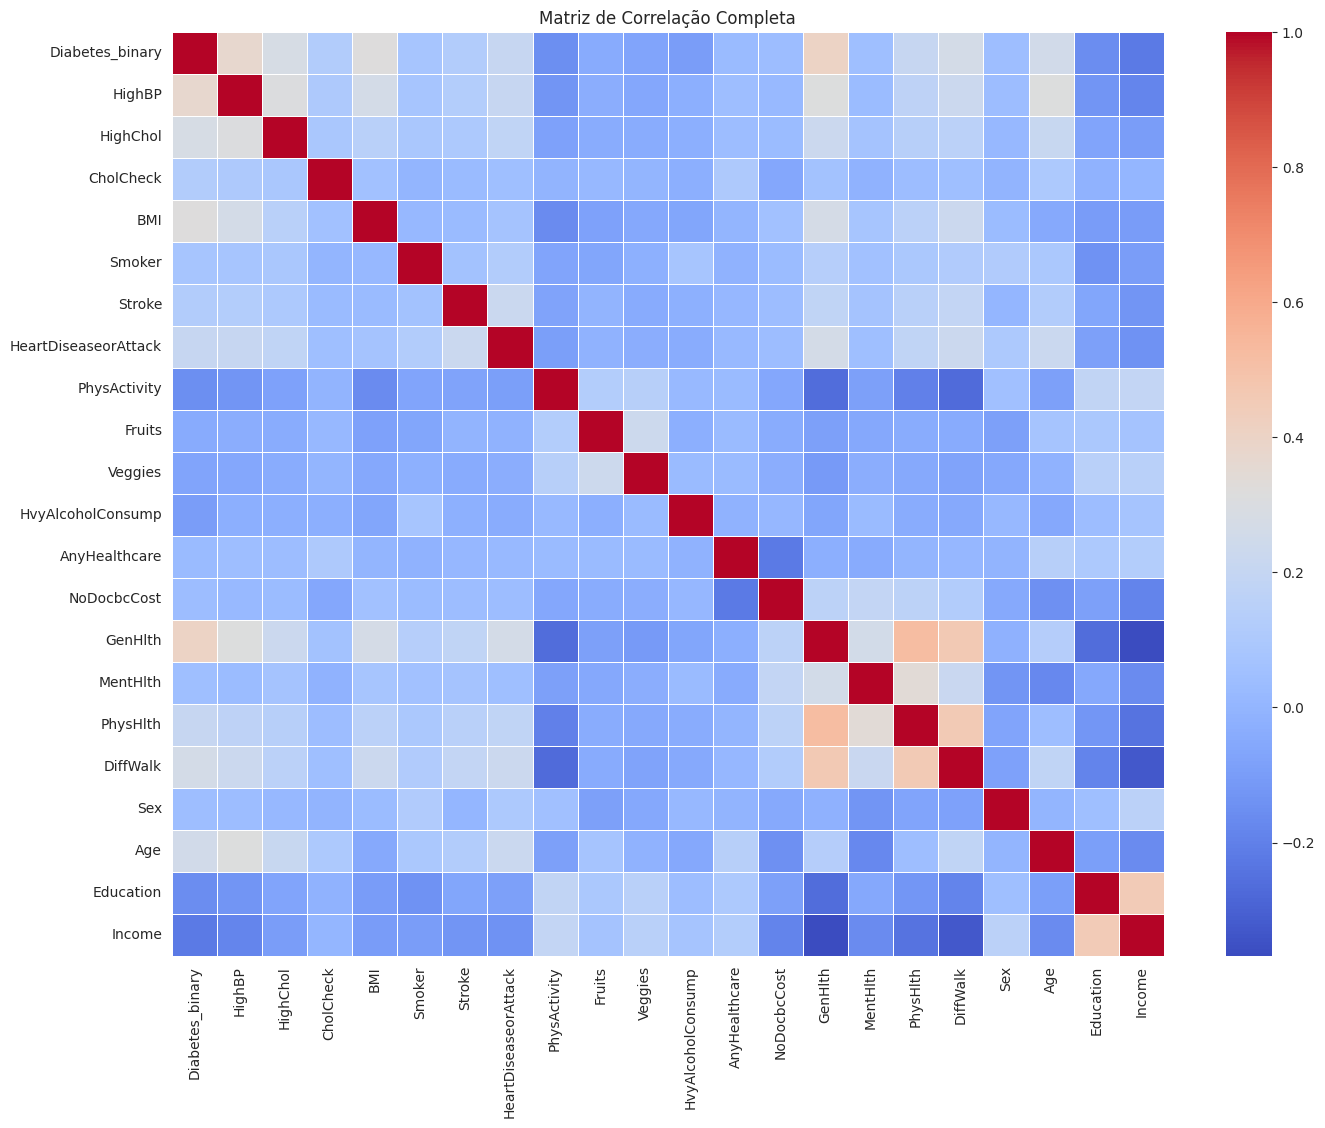


 Top 10 Fatores mais correlacionados com Diabetes:


,Diabetes_binary,GenHlth,HighBP,BMI,HighChol,DiffWalk,Age,HeartDiseaseorAttack,PhysHlth,Stroke
Diabetes_binary,1.0,0.402591,0.372048,0.319481,0.281399,0.267082,0.255355,0.207229,0.2067,0.122727



 4. PERFIL MÉDIO: SAUDÁVEL vs DIABÉTICO (Consulta SQL Agregada)


,Grupo,IMC Médio,% Pressão Alta,% Colesterol Alto,% Fumantes,% Ativ. Física,Saúde Geral (1-5),Dias Saúde Mental Ruim,Faixa Etária Média
0,Saudável,27.9,38.4,38.9,44.3,76.7,2.4,3.2,7.8
1,Diabético,32.0,75.2,66.9,51.9,62.9,3.3,4.5,9.4



 5. VISUALIZAÇÃO DETALHADA DE FATORES CRÍTICOS


/tmp/ipython-input-1217446106.py:111: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Diabetes_binary', y='BMI', data=df, ax=axes[0], palette="muted")
/tmp/ipython-input-1217446106.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(['Saudável', 'Diabético'])
/tmp/ipython-input-1217446106.py:121: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Diabetes_binary', y='Age', data=df, ax=axes[2], palette="Pastel1")
/tmp/ipython-input-1217446106.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax

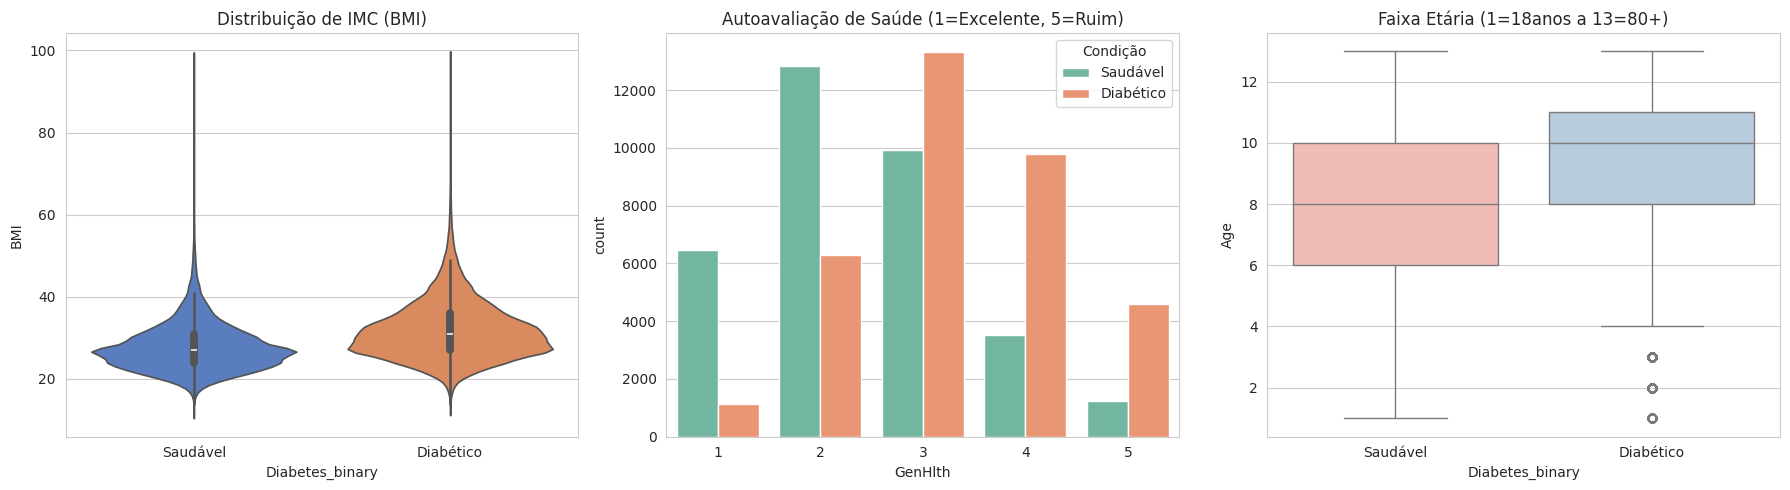


 Análise finalizada.


In [ ]:
# @title  Análise Exploratória do Banco de Dados (SQL + Pandas)
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Configurações de visualização
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

def analyze_database(db_name="diabetes_warehouse.db"):
    print(f"🔌 Conectando ao banco: {db_name}...\n")
    conn = sqlite3.connect(db_name)

    # ==============================================================================
    # 1. VISÃO GERAL E ESTATÍSTICAS BÁSICAS
    # ==============================================================================
    print(" 1. VISÃO GERAL DOS DADOS")

    # Carregar tudo para dataframe para análise estatística global
    df = pd.read_sql("SELECT * FROM diabetes_indicators", conn)

    display(df.head())
    print(f"\nDimensões: {df.shape[0]} registros, {df.shape[1]} colunas")

    print("\n Estatísticas Descritivas (Média, Desvio Padrão, Min, Max):")
    # Selecionando colunas chave para não poluir a tela
    cols_stats = ['BMI', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age', 'Income']
    display(df[cols_stats].describe().round(2))

    # ==============================================================================
    # 2. ANÁLISE DO ALVO (TARGET DISTRIBUTION)
    # ==============================================================================
    print("\n" + "="*80)
    print("2. DISTRIBUIÇÃO DA VARIÁVEL ALVO (Diabetes_binary)")

    query_target = """
    SELECT
        Diabetes_binary,
        COUNT(*) as Total,
        ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM diabetes_indicators), 2) as Porcentagem
    FROM diabetes_indicators
    GROUP BY Diabetes_binary
    """
    df_target = pd.read_sql(query_target, conn)

    # Ajustar labels para plotagem
    df_target['Label'] = df_target['Diabetes_binary'].map({0: 'Não Diabético', 1: 'Diabético'})
    display(df_target)

    # Gráfico de Pizza
    plt.figure(figsize=(6, 6))
    plt.pie(df_target['Total'], labels=df_target['Label'], autopct='%1.1f%%', colors=['#66b3ff','#ff9999'])
    plt.title('Balanceamento das Classes (Target)')
    plt.show()

    # ==============================================================================
    # 3. ANÁLISE DE CORRELAÇÃO (O que influencia mais?)
    # ==============================================================================
    print("\n" + "="*80)
    print("3. MAPA DE CORRELAÇÃO: O QUE MAIS IMPACTA A DIABETES?")
    print("   (Cores quentes = Maior relação positiva com Diabetes)")

    plt.figure(figsize=(16, 12))
    # Correlação de Spearman é boa para dados ordinais/binários
    correlation = df.corr(method='spearman')

    # Focando na coluna Diabetes_binary ordenada
    target_corr = correlation[['Diabetes_binary']].sort_values(by='Diabetes_binary', ascending=False)

    sns.heatmap(correlation, annot=False, cmap='coolwarm', linewidths=0.5)
    plt.title('Matriz de Correlação Completa')
    plt.show()

    print("\n Top 10 Fatores mais correlacionados com Diabetes:")
    display(target_corr.head(10).T)

    # ==============================================================================
    # 4. PERFILAMENTO VIA SQL (COMPARATIVO DIRETO)
    # ==============================================================================
    print("\n" + "="*80)
    print(" 4. PERFIL MÉDIO: SAUDÁVEL vs DIABÉTICO (Consulta SQL Agregada)")

    # Query complexa para tirar a "fotografia" média de cada grupo
    query_profile = """
    SELECT
        CASE WHEN Diabetes_binary = 0 THEN 'Saudável' ELSE 'Diabético' END as Grupo,
        ROUND(AVG(BMI), 1) as 'IMC Médio',
        ROUND(AVG(HighBP) * 100, 1) as '% Pressão Alta',
        ROUND(AVG(HighChol) * 100, 1) as '% Colesterol Alto',
        ROUND(AVG(Smoker) * 100, 1) as '% Fumantes',
        ROUND(AVG(PhysActivity) * 100, 1) as '% Ativ. Física',
        ROUND(AVG(GenHlth), 1) as 'Saúde Geral (1-5)',
        ROUND(AVG(MentHlth), 1) as 'Dias Saúde Mental Ruim',
        ROUND(AVG(Age), 1) as 'Faixa Etária Média'
    FROM diabetes_indicators
    GROUP BY Diabetes_binary
    """
    df_profile = pd.read_sql(query_profile, conn)
    display(df_profile)

    # ==============================================================================
    # 5. VISUALIZAÇÃO DE FATORES DE RISCO ESPECÍFICOS
    # ==============================================================================
    print("\n" + "="*80)
    print(" 5. VISUALIZAÇÃO DETALHADA DE FATORES CRÍTICOS")

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Gráfico 1: IMC (Violin Plot para ver distribuição)
    sns.violinplot(x='Diabetes_binary', y='BMI', data=df, ax=axes[0], palette="muted")
    axes[0].set_title('Distribuição de IMC (BMI)')
    axes[0].set_xticklabels(['Saudável', 'Diabético'])

    # Gráfico 2: Saúde Geral (Bar Plot)
    sns.countplot(x='GenHlth', hue='Diabetes_binary', data=df, ax=axes[1], palette="Set2")
    axes[1].set_title('Autoavaliação de Saúde (1=Excelente, 5=Ruim)')
    axes[1].legend(title='Condição', labels=['Saudável', 'Diabético'])

    # Gráfico 3: Idade (Box Plot)
    sns.boxplot(x='Diabetes_binary', y='Age', data=df, ax=axes[2], palette="Pastel1")
    axes[2].set_title('Faixa Etária (1=18anos a 13=80+)')
    axes[2].set_xticklabels(['Saudável', 'Diabético'])

    plt.tight_layout()
    plt.show()

    conn.close()
    print("\n Análise finalizada.")

# Executar a análise
analyze_database()

Principais Descobertas:

Correlação: Fatores como Saúde Geral (GenHlth), Pressão Alta (HighBP) e IMC (BMI) têm fortíssima correlação positiva com diabetes.

Fatores de Proteção: Renda (Income) e Educação mostraram correlação negativa (quanto maiores, menor o risco de diabetes).

Pré-processamento
Aplicamos a Padronização (StandardScaler) em todas as features.

Motivo: O dataset mistura variáveis binárias (0 ou 1) com variáveis de escala maior (Idade: 1-13, IMC: 12-98). Sem padronização, o modelo daria peso excessivo ao IMC apenas por ele ter números maiores.

Modelos Implementados
Modelo A: K-Nearest Neighbors (KNN)
Tipo: Aprendizado baseado em Instância (Lazy Learner).

Funcionamento: Classifica um paciente novo baseando-se na "votação" dos 5 pacientes mais parecidos (vizinhos) no banco de dados.

Configuração: k=5, distância Euclidiana.

Modelo B: Multi-Layer Perceptron (MLP)
Tipo: Rede Neural Artificial (Feedforward).

Funcionamento: Aprende padrões não-lineares complexos ajustando pesos matemáticos através de camadas ocultas de neurônios.

Configuração: 2 camadas ocultas (64 e 32 neurônios)

INICIANDO ANÁLISE DE MACHINE LEARNING

Lendo dados do SQLite...
Dividindo dados (70% Treino / 30% Teste)...
Normalizando dados (StandardScaler)...

Treinando K-Nearest Neighbors (KNN) com K=15...
Treinando Multi-Layer Perceptron (MLP) com 500 iterações...

COMPARAÇÃO DE RESULTADOS


,Métrica,KNN (Threshold=0.5),KNN (Threshold=0.3),MLP (Threshold=0.5),MLP (Threshold=0.3)
0,Acurácia,0.7273,0.7036,0.7232,0.7144
1,Precisão,0.7132,0.6470,0.7153,0.6653
2,Recall,0.7752,0.9176,0.7567,0.8817
3,F1-Score,0.7429,0.7589,0.7354,0.7583


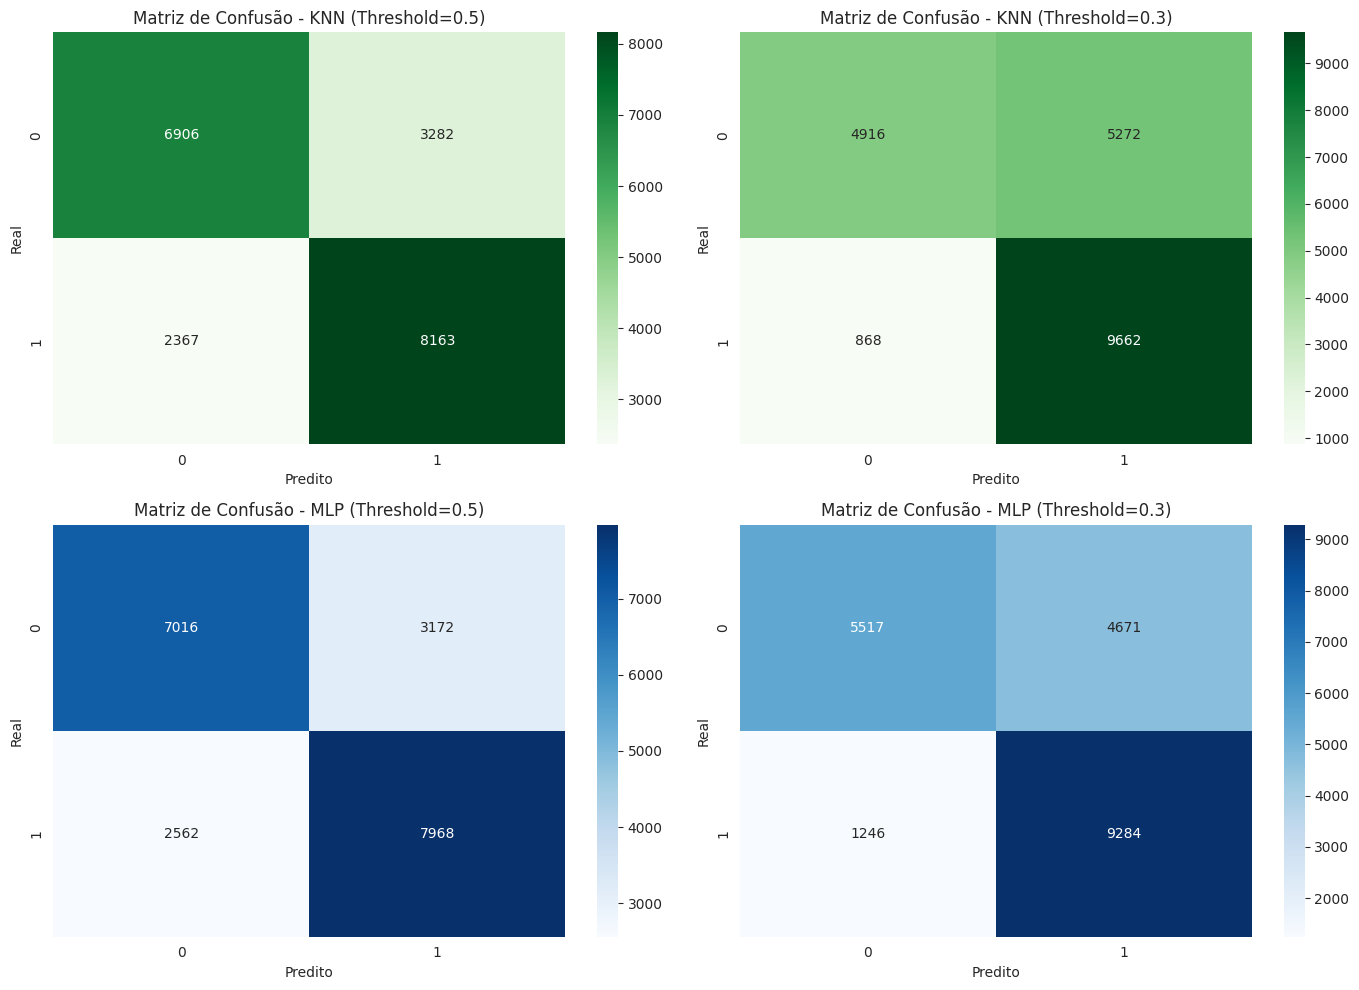

In [ ]:
# @title 3. Machine Learning: KNN vs Redes Neurais

def train_and_evaluate(db_name="diabetes_warehouse.db"):
    print("="*60)
    print("INICIANDO ANÁLISE DE MACHINE LEARNING")
    print("="*60)

    # 1. Carregar do Banco
    print("\nLendo dados do SQLite...")
    conn = sqlite3.connect(db_name)
    df = pd.read_sql("SELECT * FROM diabetes_indicators", conn)
    conn.close()

    # --- SEPARAÇÃO DE VARIÁVEIS ---
    # Cria a matriz X removendo a coluna alvo ('Diabetes_binary'), ficando apenas com as features (sintomas/dados)
    X = df.drop('Diabetes_binary', axis=1)
    # Cria o vetor y selecionando apenas a coluna alvo (a resposta que queremos prever: 0 ou 1)
    y = df['Diabetes_binary']

    # --- 2. DIVISÃO TREINO E TESTE ---
    print("Dividindo dados (70% Treino / 30% Teste)...")
    # Função vital que divide os dados.
    # test_size=0.3: Reserva 30% para teste final.
    # random_state: Garante que o sorteio seja sempre igual.
    # stratify=y: Garante a mesma proporção de doentes/saudáveis no treino e no teste.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    # --- 3. PRÉ-PROCESSAMENTO (NORMALIZAÇÃO) ---
    # Comentário original: Alerta sobre a sensibilidade do KNN e MLP à escala dos números
    print("Normalizando dados (StandardScaler)...")  # Informa o início da normalização
    scaler = StandardScaler()  # Inicializa a ferramenta que coloca os dados na mesma régua (média 0, desvio 1)

    # .fit_transform(X_train): Aprende a média/desvio DO TREINO e aplica a transformaçãonos dados de treino
    X_train_scaled = scaler.fit_transform(X_train)

    # .transform(X_test): Aplica a regra aprendida no treino aos dados de teste
    X_test_scaled = scaler.transform(X_test)

    # --- 4. MODELO KNN (VIZINHOS PRÓXIMOS) ---
    print("\nTreinando K-Nearest Neighbors (KNN) com K=15...")  # Informa início do treino KNN
    knn = KNeighborsClassifier(n_neighbors=15)  # Cria o modelo KNN configurado com K=15 (otimizado baseado em testes)
    knn.fit(X_train_scaled, y_train)  # Treina o modelo: ele "memoriza" os dados de treino normalizados e suas respostas
    y_pred_knn = knn.predict(X_test_scaled)  # Teste: O modelo tenta prever as respostas para os dados de teste (que ele nunca viu)
    y_proba_knn = knn.predict_proba(X_test_scaled)[:, 1]  # Obtém as probabilidades de ser diabético (necessário para threshold tuning)

    # --- 5. MODELO REDE NEURAL (MLP) ---
    print("Treinando Multi-Layer Perceptron (MLP) com 500 iterações...")  # Informa início do treino MLP
    # Cria a Rede Neural:
    # hidden_layer_sizes=(64, 32): Duas camadas ocultas, uma com 64 neurônios, outra com 32.
    # max_iter=500: O modelo tem até 500 tentativas para ajustar os pesos e aprender.
    # random_state=42: Semente fixa para resultados reproduzíveis.
    mlp = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
    mlp.fit(X_train_scaled, y_train)  # Treina a rede neural ajustando os pesos matemáticos com os dados de treino
    y_pred_mlp = mlp.predict(X_test_scaled)  # Teste: Gera predições usando a rede neural treinada nos dados de teste
    y_proba_mlp = mlp.predict_proba(X_test_scaled)[:, 1]  # Obtém as probabilidades de ser diabético

    # Aplicar threshold otimizado de 0.3 (ao invés do padrão 0.5)
    # Threshold menor prioriza Recall (detectar mais diabéticos), aceitando mais falsos positivos
    y_pred_knn_optimized = (y_proba_knn >= 0.3).astype(int)
    y_pred_mlp_optimized = (y_proba_mlp >= 0.3).astype(int)

    # --- 6. EXIBIÇÃO DE RESULTADOS ---
    print("\n" + "="*30)  # Linha de separação
    print("COMPARAÇÃO DE RESULTADOS")  # Título dos resultados
    print("="*30)  # Linha de separação

    # Cria um dicionário Python para organizar as métricas lado a lado
    results = {
        'Métrica': ['Acurácia', 'Precisão', 'Recall', 'F1-Score'],  # Lista com os nomes das métricas
        'KNN (Threshold=0.5)': [  # Lista com os cálculos para o KNN com threshold padrão
            accuracy_score(y_test, y_pred_knn),   # Taxa de acerto geral
            precision_score(y_test, y_pred_knn),  # Qualidade do positivo (evita alarme falso)
            recall_score(y_test, y_pred_knn),     # Capacidade de achar a doença (evita falso negativo)
            f1_score(y_test, y_pred_knn)          # Média harmônica entre precisão e recall
        ],
        'KNN (Threshold=0.3)': [  # Lista com os cálculos para o KNN com threshold otimizado
            accuracy_score(y_test, y_pred_knn_optimized),
            precision_score(y_test, y_pred_knn_optimized),
            recall_score(y_test, y_pred_knn_optimized),
            f1_score(y_test, y_pred_knn_optimized)
        ],
        'MLP (Threshold=0.5)': [  # Lista com os cálculos para a Rede Neural com threshold padrão
            accuracy_score(y_test, y_pred_mlp),
            precision_score(y_test, y_pred_mlp),
            recall_score(y_test, y_pred_mlp),
            f1_score(y_test, y_pred_mlp)
        ],
        'MLP (Threshold=0.3)': [  # Lista com os cálculos para a Rede Neural com threshold otimizado
            accuracy_score(y_test, y_pred_mlp_optimized),
            precision_score(y_test, y_pred_mlp_optimized),
            recall_score(y_test, y_pred_mlp_optimized),
            f1_score(y_test, y_pred_mlp_optimized)
        ]
    }

    results_df = pd.DataFrame(results)  # Converte o dicionário em um DataFrame do Pandas (tabela)
    display(results_df.round(4))  # Exibe a tabela no Colab arredondando para 4 casas decimais

    # --- VISUALIZAÇÃO GRÁFICA (MATRIZES) ---
    # Cria uma figura com 4 gráficos (subplots) lado a lado (2 linhas, 2 colunas), tamanho 14x10
    fig, ax = plt.subplots(2, 2, figsize=(14, 10))

    # Desenha o Heatmap (mapa de calor) para o KNN com threshold padrão na posição (0,0)
    # annot=True: Escreve os números nas caixas; fmt='d': Formato inteiro (sem vírgula); cmap='Greens': Cor verde
    sns.heatmap(confusion_matrix(y_test, y_pred_knn), annot=True, fmt='d', cmap='Greens', ax=ax[0,0])
    ax[0,0].set_title('Matriz de Confusão - KNN (Threshold=0.5)')  # Define o título do gráfico
    ax[0,0].set_xlabel('Predito')  # Define o rótulo do eixo X
    ax[0,0].set_ylabel('Real')     # Define o rótulo do eixo Y

    # Desenha o Heatmap para o KNN com threshold otimizado na posição (0,1)
    sns.heatmap(confusion_matrix(y_test, y_pred_knn_optimized), annot=True, fmt='d', cmap='Greens', ax=ax[0,1])
    ax[0,1].set_title('Matriz de Confusão - KNN (Threshold=0.3)')
    ax[0,1].set_xlabel('Predito')
    ax[0,1].set_ylabel('Real')

    # Desenha o Heatmap para a Rede Neural com threshold padrão na posição (1,0), usando cor Azul ('Blues')
    sns.heatmap(confusion_matrix(y_test, y_pred_mlp), annot=True, fmt='d', cmap='Blues', ax=ax[1,0])
    ax[1,0].set_title('Matriz de Confusão - MLP (Threshold=0.5)')  # Define o título do gráfico
    ax[1,0].set_xlabel('Predito')  # Rótulo eixo X
    ax[1,0].set_ylabel('Real')     # Rótulo eixo Y

    # Desenha o Heatmap para a Rede Neural com threshold otimizado na posição (1,1)
    sns.heatmap(confusion_matrix(y_test, y_pred_mlp_optimized), annot=True, fmt='d', cmap='Blues', ax=ax[1,1])
    ax[1,1].set_title('Matriz de Confusão - MLP (Threshold=0.3)')
    ax[1,1].set_xlabel('Predito')
    ax[1,1].set_ylabel('Real')

    plt.tight_layout()  # Ajusta automaticamente os espaçamentos para nada ficar sobreposto
    plt.show()  # Renderiza e mostra os gráficos na tela

# Executar ML
train_and_evaluate(db_path)